In [1]:
import os

try:
    has_changed_dir
except:
    has_changed_dir = False

try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

if IN_COLAB:
    %pip install datasets
    %pip install translate-toolkit
    %pip install bitsandbytes
    %pip install einops

    !git clone https://github.com/MarkusSibbesen/mechinterp_research_project.git

    from google.colab import drive
    drive.mount('/content/drive/')

    if not has_changed_dir:
        os.chdir('mechinterp_research_project')
        has_changed_dir = True
else:
    if not has_changed_dir:
        os.chdir('.')
        has_changed_dir = True


In [2]:
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer

from src.dataset_handling import TextDataset, TextClassificationDataset
from src.utils import get_hidden_activations, activation_label_generator
from src.sparse_autoencoders import SAE_topk
import tqdm.auto as tqdm

import json
import pandas as pd
import os
from matplotlib import pyplot as plt
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# For the base model
url = "EleutherAI/pythia-14m"
hookpoints = ["gpt_neox.layers.3.mlp.act"]
out_folder = f"models/sparse_autoencoders/{url.split('/')[-1]}"
log_folder = f"training_logs/sparse_autoencoders/{url.split('/')[-1]}"

model = AutoModelForCausalLM.from_pretrained(url).to(device)
tokenizer = AutoTokenizer.from_pretrained(url)
batch_size = 32
learning_rate = 1e-3

data_path = 'data/split/tedtalks_train.tsv'
data = TextClassificationDataset.from_tsv(data_path)

dataloader = DataLoader(
    dataset=data,
    batch_size=batch_size,
    shuffle=True
)

In [4]:
# SAE data

input_size = model.config.intermediate_size

expansion_factor = 4

meta_data = {
    'input_size': input_size,
    'hidden_size': input_size * expansion_factor,
    'k': 8,
    "pre_encoder_bias": True,
    "same_W": False
}


sae = SAE_topk(meta_data=meta_data).to(device)

In [5]:
class SaeTrainer():
    def __init__(self, meta_data, learning_rate, hookpoint, device):
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.hookpoint = hookpoint

        self.model = SAE_topk(meta_data).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()

        self.batches = 0

        self.losses = []


    def train_step(self, input_, labels):
        outputs = self.model(input_).to(device)
        loss = self.loss_fn(outputs, labels)
        hiddens = self.model.activations
        active_neurons = len(torch.unique(hiddens.indices))

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        self.losses.append((loss.item(), active_neurons))
        self.batches += 1
        return loss, active_neurons

    def plot_loss(self, out_file = None):
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        losses, active_neurons = zip(*self.losses)
        ax.plot(losses, label='Loss')
        ax2 = ax.twinx()
        ax2.plot(active_neurons, label='Active neurons', color='orange')
        ax.set_xlabel('batch nr')
        ax.set_ylabel('loss')
        ax2.set_ylabel(f'active neurons per batch (batch_size: {batch_size})')
        ax.set_title(self.hookpoint)
        fig.legend()

        if out_file:
            fig.savefig(out_file, dpi=300)
        else:
            plt.show()

In [6]:
sae_trainers = [
    SaeTrainer(meta_data, learning_rate, hookpoint, device)
    for hookpoint in hookpoints
]

In [7]:
for activations, _ in activation_label_generator(dataloader, model, hookpoints, tokenizer, device):
    for sae_trainer in sae_trainers:
        activation = activations[sae_trainer.hookpoint]
        label = activation.detach()
        loss, active_neurons = sae_trainer.train_step(activation, label)
        print(f'{loss}\t{active_neurons}', end='')
    print('')

  0%|          | 0/2070 [00:00<?, ?it/s]

0.08027731627225876	142
0.08392000943422318	120
0.07606428116559982	117
0.07389500737190247	115
0.0748942419886589	111
0.07017537206411362	112
0.06837673485279083	108
0.062315985560417175	108
0.06415773928165436	108
0.06019400432705879	107
0.057751063257455826	106
0.05543184652924538	107
0.05165049806237221	105
0.0494844913482666	104
0.04897826910018921	104
0.04525796324014664	104
0.044383853673934937	103
0.04020035266876221	104
0.039547841995954514	102
0.03803500160574913	103
0.037209343165159225	105
0.0365043580532074	105
0.03508105129003525	105
0.03328334540128708	105
0.03234615921974182	105
0.03282617777585983	105
0.032123271375894547	104
0.030868656933307648	104
0.029935836791992188	105
0.029426254332065582	105
0.029297811910510063	105
0.02858937717974186	105
0.028068475425243378	105
0.02849626913666725	105
0.027145883068442345	105
0.0277671217918396	105
0.02705634944140911	105
0.026528552174568176	105
0.02620186284184456	105
0.025744762271642685	105
0.02628006413578987	105
0.0256

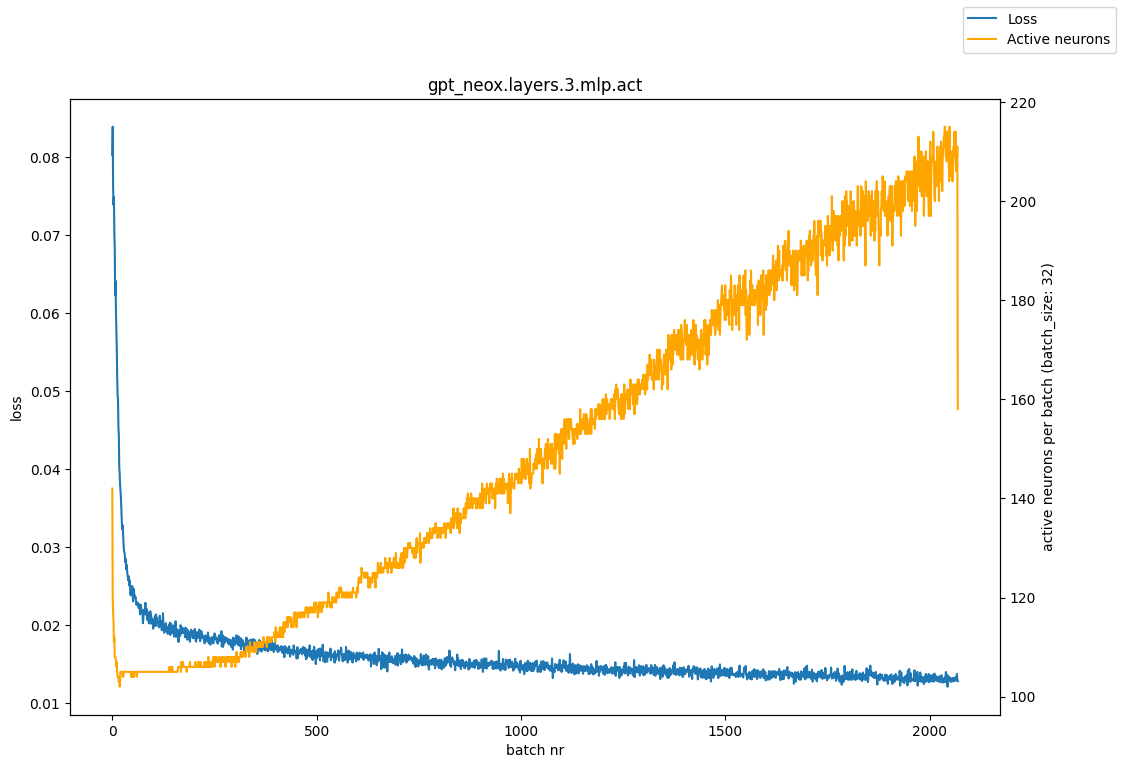

In [8]:
for sae_trainer in sae_trainers:
    hookpoint = sae_trainer.hookpoint
    k = sae_trainer.model.meta_data['k']

    model_out_path = f'{out_folder}/topk{k}/{hookpoint}.pt'
    # model_out_path = f'../drive/MyDrive/models/{hookpoint}.pt'
    meta_data_out_path = f'{out_folder}/topk{k}/{hookpoint}.json'
    log_path = f'{log_folder}/topk{k}/{hookpoint}.csv'
    log_fig_path = f'{log_folder}/topk{k}/{hookpoint}.png'


    if not os.path.isdir(f'{out_folder}'):
        os.mkdir(f'{out_folder}')
    if not os.path.isdir(f'{log_folder}'):
        os.mkdir(f'{log_folder}')

    if not os.path.isdir(f'{out_folder}/topk{k}'):
        os.mkdir(f'{out_folder}/topk{k}')
    if not os.path.isdir(f'{log_folder}/topk{k}'):
        os.mkdir(f'{log_folder}/topk{k}')

    torch.save(sae_trainer.model.state_dict(), model_out_path)

    new_meta = {key: value for key, value in meta_data.items()}
    new_meta['batch_size'] = batch_size
    new_meta['num_batches_trained_on'] = sae_trainer.batches
    new_meta['hookpoint'] = sae_trainer.hookpoint
    new_meta['learning_rate'] = learning_rate

    with open(meta_data_out_path, 'w') as file:
        json.dump(new_meta, file, indent=4)

    loss_log, active_neurons_log = zip(*sae_trainer.losses)
    df = pd.DataFrame({
        'loss': loss_log,
        'active_neurons': active_neurons_log
    })
    df.to_csv(log_path)

    sae_trainer.plot_loss(out_file=log_fig_path)

In [10]:
!git add {out_folder}
!git add {log_folder}
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	new file:   models/sparse_autoencoders/pythia-1.4b/topk32/gpt_neox.layers.16.mlp.act.json
	new file:   training_logs/sparse_autoencoders/pythia-1.4b/topk32/gpt_neox.layers.16.mlp.act.csv
	new file:   training_logs/sparse_autoencoders/pythia-1.4b/topk32/gpt_neox.layers.16.mlp.act.png



In [12]:
!git config --global user.email
!git config --global user.name "Markus Sibbesen"

In [13]:
!git commit -m "meta data and logs for big model trained"

[main 19cccbe] meta data and logs for big model trained
 3 files changed, 2082 insertions(+)
 create mode 100644 models/sparse_autoencoders/pythia-1.4b/topk32/gpt_neox.layers.16.mlp.act.json
 create mode 100644 training_logs/sparse_autoencoders/pythia-1.4b/topk32/gpt_neox.layers.16.mlp.act.csv
 create mode 100644 training_logs/sparse_autoencoders/pythia-1.4b/topk32/gpt_neox.layers.16.mlp.act.png


In [14]:
!git push

Enumerating objects: 17, done.
Counting objects: 100% (17/17), done.
Delta compression using up to 12 threads
Compressing objects: 100% (11/11), done.
Writing objects: 100% (13/13), 380.03 KiB | 13.10 MiB/s, done.
Total 13 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/MarkusSibbesen/mechinterp_research_project.git
   498dc99..19cccbe  main -> main
